## Assignment 2 Deep Learning - CNNs

_Magnus Caesar_

In [57]:
import numpy as np
import torch
import torch.utils.data as data
from load_mnist import *
import matplotlib.pyplot as plt 
np.random.seed(42)


### Exercise 1. Multi-layer fully connected neural network
Implement exactly the same network as for assignment 1.

1. Compare the performance
2. Compare speed
3. Learning curve plot

The first network from assignment 1 is a linear model. The input dimension is 784 (28x28 pixels) and the output dimension is 10. The second network is multilayered. The one I implemented had 2 hidden layers á 100 neurons each, which the same necessary input and output dimensions.

In [ ]:
# Load the data
X_train, Y_train, X_test, Y_test = load_mnist()

In [159]:
# Loading the data into pytorch's domain

X_train_tensor = torch.tensor(X_train, dtype=torch.float32) # has to be float32
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)  # only works with long in cross entropy loss ?? so dumb

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Create TensorDataset
train_dataset = data.TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor, Y_test_tensor)


**Base network and forward**

Basic class for the network.

In [109]:
class SeqNetwork(torch.nn.Module):
    def __init__(self, num_hidden_layers, input_dim=784, output_dim=10, hidden_dim=100):
        super().__init__()
        self.layers = torch.nn.ModuleList([]) # Ska ha lista med lager / moduler

        # If no hidden layers
        if num_hidden_layers == 0: 
            self.layers.append(torch.nn.Linear(input_dim, output_dim, dtype=torch.float32))

        # If hidden layers layers
        # TODO
        # this might have some logic flaws
        else:
            # First layer
            self.layers.append(torch.nn.Linear(input_dim, hidden_dim))
            self.layers.append(torch.nn.ReLU())
            
            # Add extra layers
            for _ in range(num_hidden_layers):
                self.layers.append(torch.nn.Linear(hidden_dim, hidden_dim))
                self.layers.append(torch.nn.ReLU())
            
            self.layers.append(torch.nn.Linear(hidden_dim, output_dim))
        

    def forward(self, x):

        for l in self.layers:
            x = l(x)

        return x
        

**Computing loss**

This is the exact same "compute_loss" function used in lab 2.

In [208]:
def compute_loss(model, batch):
    # forward pass and loss function

    inp_data, labels = batch # Read current batch

    output = model(inp_data) # Get output from model
    loss = torch.nn.functional.cross_entropy(output, labels)
    acc = (output.argmax(dim=1) == labels.argmax(dim=1)).float().mean() # Check accuracy

    return loss, acc

**Optimizing**

The optimizer is SGD (as opposed to ADAM which comes later). PyTorch supports momentum, but that wasn't used in lab 1 and so won't be used here either.

In [220]:
model = SeqNetwork(0)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)

num_epochs = 50
batch_size = 64 # size used in lab1

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=64)



# Utilize mini-batch gradient descent
# After each batch: collect training cost and accuracy
# After each epoch (all batches: full data set)
# Epochs training accuracy is the average
# After each epoch: calculate test cost and accuracy

# These four lists are requested in the assignment
# Every batch
train_accuracies = []
train_costs = []

# Every epoch
test_costs = []
test_accuracies = []

# Same training structure as from lab 2
for epoch in range(num_epochs):
    model.train()
    print(f"Entering epoch {epoch+1} out of {num_epochs}.")

    for b in train_loader:
        optimizer.zero_grad()
        loss, train_acc = compute_loss(model, b)
        loss.backward()
        optimizer.step()

        # Appending training metrics
        train_costs.append(loss.item())
        train_accuracies.append(train_acc)
    
    # Appending test metrics
    temp_costs = []
    temp_acc = []
    for b in test_loader:
        loss, acc = compute_loss(model, b)
        temp_costs.append(loss.item())
        temp_acc.append(acc)
    
    test_costs.append(np.mean(temp_costs))
    test_accuracies.append(np.mean(temp_acc))

    print(f"Current testing loss: {test_costs[-1]}")
    print(f"Current test accuracy: {test_accuracies[-1]}")
    print()




Entering epoch 1 out of 50.
Current testing loss: 1.6039764630566737
Current test accuracy: 0.7349721193313599

Entering epoch 2 out of 50.
Current testing loss: 1.2250427793545329
Current test accuracy: 0.7974721193313599

Entering epoch 3 out of 50.
Current testing loss: 1.017464569040165
Current test accuracy: 0.8211584687232971

Entering epoch 4 out of 50.
Current testing loss: 0.8901389330435711
Current test accuracy: 0.8351910710334778

Entering epoch 5 out of 50.
Current testing loss: 0.8042546703367476
Current test accuracy: 0.8438495397567749

Entering epoch 6 out of 50.
Current testing loss: 0.742360804111335
Current test accuracy: 0.8497213125228882

Entering epoch 7 out of 50.
Current testing loss: 0.6953884675434441
Current test accuracy: 0.856289803981781

Entering epoch 8 out of 50.
Current testing loss: 0.658515371050045
Current test accuracy: 0.8608678579330444

Entering epoch 9 out of 50.
Current testing loss: 0.6286549715289644
Current test accuracy: 0.86504775285720

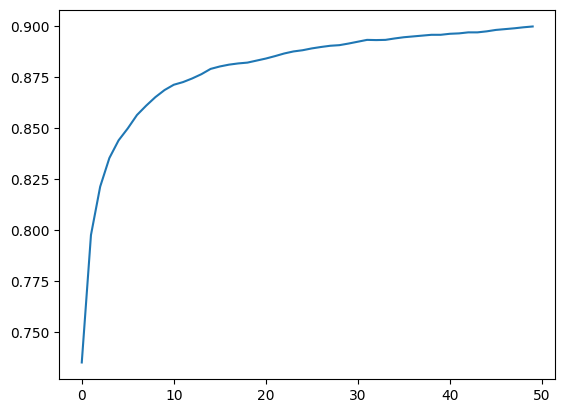

In [221]:
plt.plot(range(len(test_accuracies)), test_accuracies)

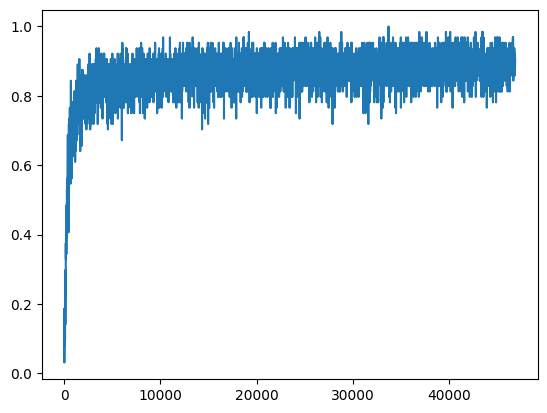

In [222]:
plt.plot(range(len(train_accuracies))[::10], train_accuracies[::10])

In [ ]:
model = SeqNetwork(3)
X_temp = X_train[0].astype("double")

# inputs have to be changed from numpy's standard 64float to 32float
X_p = torch.tensor(X_temp.reshape(1, -1), dtype=torch.float32)

print(X_p.size())
print(X_p.dtype)
model(X_p) 


torch.Size([1, 784])
torch.float32


tensor([[-0.0018, -0.0698, -0.0844,  0.0108,  0.0614, -0.0714, -0.0255, -0.0352,
         -0.0841,  0.0481]], grad_fn=<AddmmBackward0>)

### Exercise 2. Multilayer convolutional neural network
CNN using PyTorch with SGD and cross-entropy loss. Reach 98% accuracy.

1. How many learnable weights does the network contain? Compare with previous exercise.
2. Learning curve plot.